In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
d = pd.read_csv("term-deposit-marketing-2020.csv")
print(d.shape)
d.head()

(40000, 14)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [3]:
d.y.value_counts()

no     37104
yes     2896
Name: y, dtype: int64

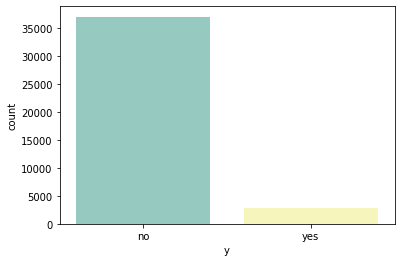

In [4]:
#plt.figure(figsize=(10,5))
sns.countplot(x= "y", data=d, palette="Set3")

##### Target variable is imbalanced

In [5]:
d.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

In [6]:
d_num = d[['age', 'balance', 'day', 'duration', 'campaign', 'y']]

In [7]:
d_num.head()

,age,balance,day,duration,campaign,y
0,58,2143,5,261,1,no
1,44,29,5,151,1,no
2,33,2,5,76,1,no
3,47,1506,5,92,1,no
4,33,1,5,198,1,no


In [8]:
d.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


In [9]:
d_num['y'] = d_num.y.map(dict(yes=1, no=0))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
d_num.head()

,age,balance,day,duration,campaign,y
0,58,2143,5,261,1,0
1,44,29,5,151,1,0
2,33,2,5,76,1,0
3,47,1506,5,92,1,0
4,33,1,5,198,1,0


In [11]:
d.y.value_counts()

no     37104
yes     2896
Name: y, dtype: int64

##### running models with just numeric features

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc

In [13]:
# function for Confusion matrix, Classification Report and ROC-Curve

def classif_report(Y_test, Y_pred, pred_prob):
    print("\n", "Confusion Matrix")
    c_matrix = confusion_matrix(Y_test, Y_pred)
    ax = sns.heatmap(c_matrix, square = True,  annot=True, cbar=False, fmt = 'g', cmap="RdBu",   
                xticklabels=['0', '1'], yticklabels=['0', '1'])
    #heatmap getting truncated so added below to extend the plot
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    custom_ylim = (b, t)
    plt.setp(ax, ylim=custom_ylim)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()
    print("\n", "Classification Report", "\n")
    print(classification_report(Y_test, Y_pred))
    print("Accuracy: ",accuracy_score(Y_test, Y_pred))
    print("Precision Score: ", precision_score(Y_test, Y_pred))
    print("Recall Score: ", recall_score(Y_test, Y_pred))
    print("F1 Score: ", f1_score(Y_test, Y_pred))
    pred_prob_one = pred_prob[:,1]
    fpr, tpr, thresholds = roc_curve(Y_test, pred_prob_one)
    roc_auc = auc(fpr, tpr)
    print("AUC: ", roc_auc)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC Curve (Area = %0.2f)' % roc_auc)
    plt.plot([0.0, 1.0], [0, 1],'r--')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC on Test Data')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()
    print("----------------------------------------------------------------------------------------")
    print("----------------------------------------------------------------------------------------")

In [14]:
Y = d_num['y']
X = d_num.drop('y', axis=1)

In [15]:
#train:test = 0.85:0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.85, random_state = 21, stratify=Y)

In [16]:
print("Train Data Dimensions : ", X_train.shape)
print("Test Data Dimensions : ", X_test.shape)

Train Data Dimensions :  (34000, 5)
Test Data Dimensions :  (6000, 5)


In [17]:
#function to run different models

def model_data(XTr, XTe, YTr, YTe):
    
    print("\n", "Logistic Regression")
    clf_model = LogisticRegression()
    clf_model.fit(XTr, YTr)
    Y_pred = clf_model.predict(XTe)
    pred_prob = clf_model.predict_proba(XTe)
    classif_report(YTe, Y_pred, pred_prob)   
    
#    print("\n", "Naive Bayes")
#    clf_model = MultinomialNB()
#    clf_model.fit(XTr, YTr)
#    Y_pred = clf_model.predict(XTe)
#    pred_prob = clf_model.predict_proba(XTe)
#    classif_report(YTe, Y_pred, pred_prob)
    
    print("\n", "Decision Tree")
    clf_model = DecisionTreeClassifier()
    clf_model.fit(XTr, YTr)
    Y_pred = clf_model.predict(XTe)
    pred_prob = clf_model.predict_proba(XTe)
    classif_report(YTe, Y_pred, pred_prob)    
    
    print("\n", "Random Forest")
    clf_model = RandomForestClassifier()
    clf_model.fit(XTr, YTr)
    Y_pred = clf_model.predict(XTe)
    pred_prob = clf_model.predict_proba(XTe)
    classif_report(YTe, Y_pred, pred_prob)
    
    print("\n", "Gradient Boosting")
    clf_model = GradientBoostingClassifier()
    clf_model.fit(XTr, YTr)
    Y_pred = clf_model.predict(XTe)
    pred_prob = clf_model.predict_proba(XTe)
    classif_report(YTe, Y_pred, pred_prob)   


 Logistic Regression

 Confusion Matrix


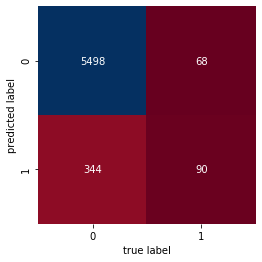


 Classification Report 

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5566
           1       0.57      0.21      0.30       434

    accuracy                           0.93      6000
   macro avg       0.76      0.60      0.63      6000
weighted avg       0.91      0.93      0.92      6000

Accuracy:  0.9313333333333333
Precision Score:  0.569620253164557
Recall Score:  0.2073732718894009
F1 Score:  0.30405405405405406
AUC:  0.8750668558777701


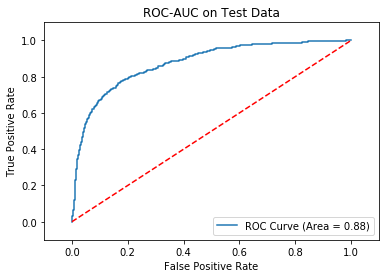

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

 Decision Tree

 Confusion Matrix


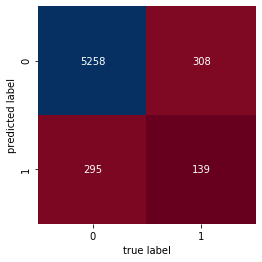


 Classification Report 

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      5566
           1       0.31      0.32      0.32       434

    accuracy                           0.90      6000
   macro avg       0.63      0.63      0.63      6000
weighted avg       0.90      0.90      0.90      6000

Accuracy:  0.8995
Precision Score:  0.31096196868008946
Recall Score:  0.32027649769585254
F1 Score:  0.3155505107832009
AUC:  0.6324702646582029


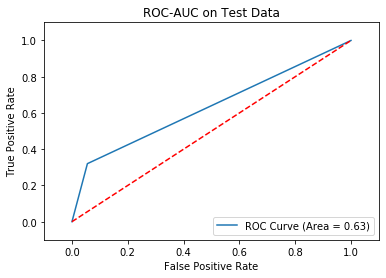

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

 Random Forest

 Confusion Matrix


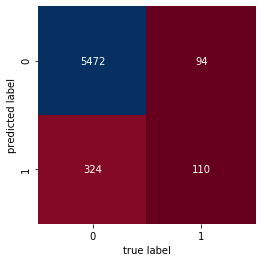


 Classification Report 

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      5566
           1       0.54      0.25      0.34       434

    accuracy                           0.93      6000
   macro avg       0.74      0.62      0.65      6000
weighted avg       0.91      0.93      0.92      6000

Accuracy:  0.9303333333333333
Precision Score:  0.5392156862745098
Recall Score:  0.2534562211981567
F1 Score:  0.3448275862068966
AUC:  0.878203700545279


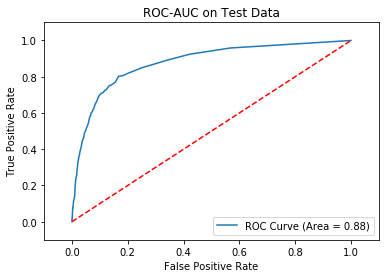

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

 Gradient Boosting

 Confusion Matrix


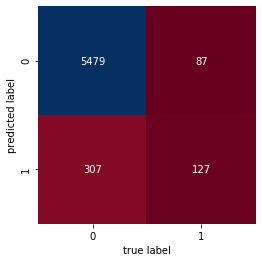


 Classification Report 

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      5566
           1       0.59      0.29      0.39       434

    accuracy                           0.93      6000
   macro avg       0.77      0.64      0.68      6000
weighted avg       0.92      0.93      0.92      6000

Accuracy:  0.9343333333333333
Precision Score:  0.5934579439252337
Recall Score:  0.2926267281105991
F1 Score:  0.39197530864197533
AUC:  0.9013383180634232


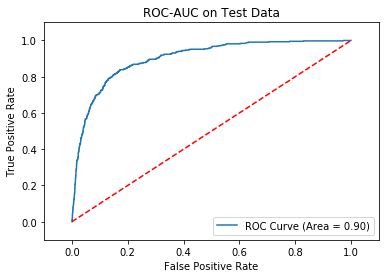

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------


In [18]:
model_data(X_train, X_test, Y_train, Y_test)

## Naive bayes threw a value error, negative values passed as input - how to tackle this? Balance is negative hence the error

#### Running model using all the features

In [19]:
d_all = d
d_all.shape

(40000, 14)

In [20]:
d_all['y'] = d_all.y.map(dict(yes=1, no=0))

In [21]:
d_all.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'y'],
      dtype='object')

In [22]:
d_all.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
y             int64
dtype: object

In [23]:
#creating dummy variables for categorical variables
cols_to_transform = ['job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'month']

In [24]:
df_with_dummies = pd.get_dummies(data = d_all, columns = cols_to_transform )

In [25]:
df_with_dummies.head()

,age,balance,day,duration,campaign,y,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,2143,5,261,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,44,29,5,151,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,33,2,5,76,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,47,1506,5,92,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,33,1,5,198,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [26]:
df_with_dummies.shape

(40000, 45)

In [27]:
df_with_dummies.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'y', 'job_admin',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct'],
      dtype='object')

In [28]:
Y = df_with_dummies['y']
X = df_with_dummies.drop('y', axis=1)
#train:test = 0.85:0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.85, random_state = 21, stratify=Y)
print("Train Data Dimensions : ", X_train.shape)
print("Test Data Dimensions : ", X_test.shape)

Train Data Dimensions :  (34000, 44)
Test Data Dimensions :  (6000, 44)



 Logistic Regression

 Confusion Matrix


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


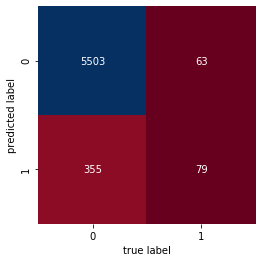


 Classification Report 

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5566
           1       0.56      0.18      0.27       434

    accuracy                           0.93      6000
   macro avg       0.75      0.59      0.62      6000
weighted avg       0.91      0.93      0.91      6000

Accuracy:  0.9303333333333333
Precision Score:  0.5563380281690141
Recall Score:  0.18202764976958524
F1 Score:  0.2743055555555555
AUC:  0.8653145910572915


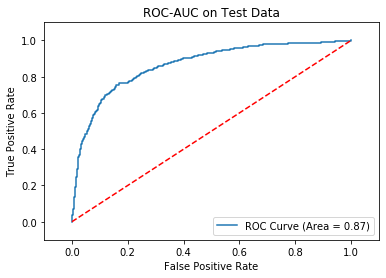

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

 Decision Tree

 Confusion Matrix


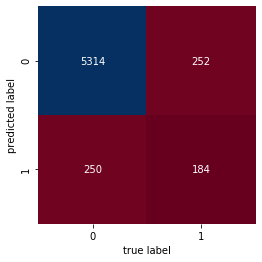


 Classification Report 

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      5566
           1       0.42      0.42      0.42       434

    accuracy                           0.92      6000
   macro avg       0.69      0.69      0.69      6000
weighted avg       0.92      0.92      0.92      6000

Accuracy:  0.9163333333333333
Precision Score:  0.42201834862385323
Recall Score:  0.423963133640553
F1 Score:  0.42298850574712643
AUC:  0.6893441252105029


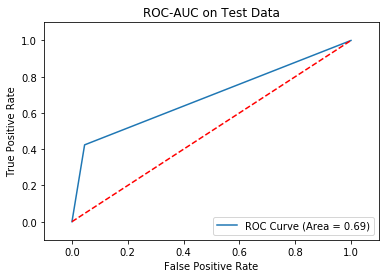

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

 Random Forest

 Confusion Matrix


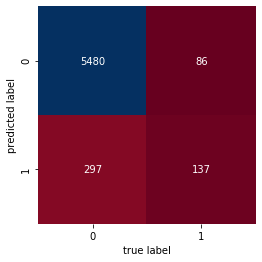


 Classification Report 

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      5566
           1       0.61      0.32      0.42       434

    accuracy                           0.94      6000
   macro avg       0.78      0.65      0.69      6000
weighted avg       0.92      0.94      0.93      6000

Accuracy:  0.9361666666666667
Precision Score:  0.6143497757847534
Recall Score:  0.315668202764977
F1 Score:  0.4170471841704719
AUC:  0.935246253173067


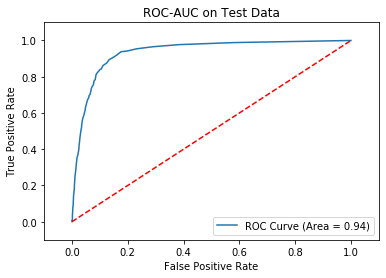

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

 Gradient Boosting

 Confusion Matrix


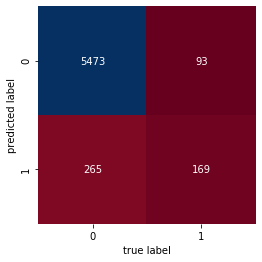


 Classification Report 

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      5566
           1       0.65      0.39      0.49       434

    accuracy                           0.94      6000
   macro avg       0.80      0.69      0.73      6000
weighted avg       0.93      0.94      0.93      6000

Accuracy:  0.9403333333333334
Precision Score:  0.6450381679389313
Recall Score:  0.38940092165898615
F1 Score:  0.48563218390804597
AUC:  0.9449384925924516


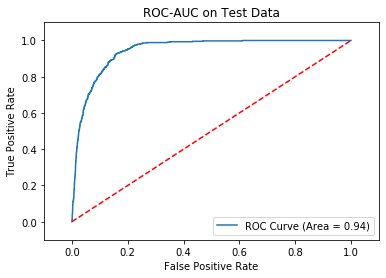

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------


In [29]:
model_data(X_train, X_test, Y_train, Y_test)

In [30]:
#Let's run the models again, this time standardizing the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(df_with_dummies) 
df_with_dummies.loc[:,:] = scaled_values

In [31]:
df_with_dummies.head()

,age,balance,day,duration,campaign,y,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,0.513158,0.092259,0.133333,0.053070,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.328947,0.073067,0.133333,0.030704,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.184211,0.072822,0.133333,0.015453,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.368421,0.086476,0.133333,0.018707,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.184211,0.072812,0.133333,0.040260,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [32]:
Y = df_with_dummies['y']
X = df_with_dummies.drop('y', axis=1)
#train:test = 0.85:0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.85, random_state = 21, stratify=Y)
print("Train Data Dimensions : ", X_train.shape)
print("Test Data Dimensions : ", X_test.shape)

Train Data Dimensions :  (34000, 44)
Test Data Dimensions :  (6000, 44)



 Logistic Regression

 Confusion Matrix


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


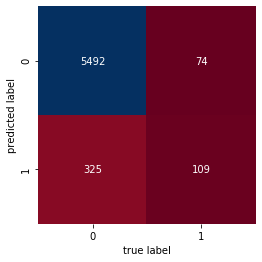


 Classification Report 

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96      5566
         1.0       0.60      0.25      0.35       434

    accuracy                           0.93      6000
   macro avg       0.77      0.62      0.66      6000
weighted avg       0.92      0.93      0.92      6000

Accuracy:  0.9335
Precision Score:  0.5956284153005464
Recall Score:  0.2511520737327189
F1 Score:  0.35332252836304706
AUC:  0.9227158472026508


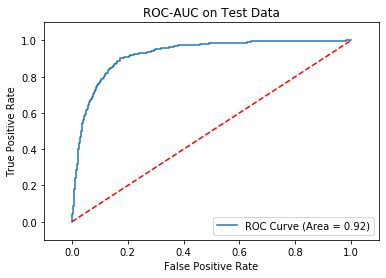

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

 Decision Tree

 Confusion Matrix


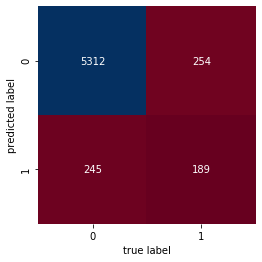


 Classification Report 

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96      5566
         1.0       0.43      0.44      0.43       434

    accuracy                           0.92      6000
   macro avg       0.69      0.69      0.69      6000
weighted avg       0.92      0.92      0.92      6000

Accuracy:  0.9168333333333333
Precision Score:  0.42663656884875845
Recall Score:  0.43548387096774194
F1 Score:  0.43101482326111745
AUC:  0.6949248316390991


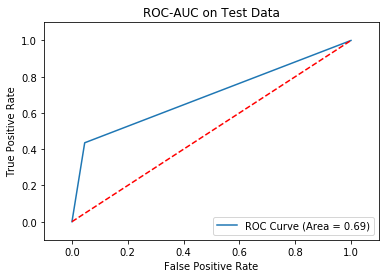

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

 Random Forest

 Confusion Matrix


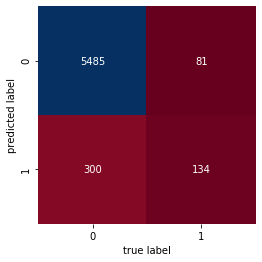


 Classification Report 

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      5566
         1.0       0.62      0.31      0.41       434

    accuracy                           0.94      6000
   macro avg       0.79      0.65      0.69      6000
weighted avg       0.92      0.94      0.93      6000

Accuracy:  0.9365
Precision Score:  0.6232558139534884
Recall Score:  0.3087557603686636
F1 Score:  0.41294298921417566
AUC:  0.9354987738259446


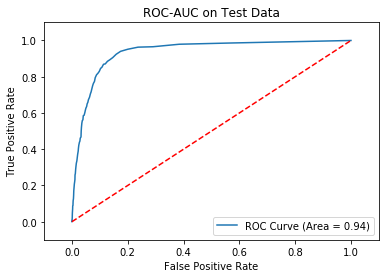

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

 Gradient Boosting

 Confusion Matrix


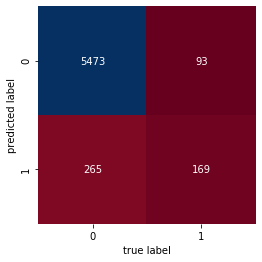


 Classification Report 

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97      5566
         1.0       0.65      0.39      0.49       434

    accuracy                           0.94      6000
   macro avg       0.80      0.69      0.73      6000
weighted avg       0.93      0.94      0.93      6000

Accuracy:  0.9403333333333334
Precision Score:  0.6450381679389313
Recall Score:  0.38940092165898615
F1 Score:  0.48563218390804597
AUC:  0.945171556736009


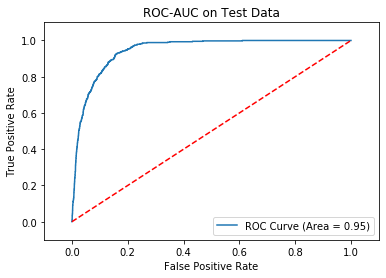

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------


In [33]:
model_data(X_train, X_test, Y_train, Y_test)

## Noticing no change in AUC occuring due to scaling features for tree based models 

# <font color='red'>Review for 1/1/2021 Call</font> 

#### Cross-validation with different Classifier models

In [34]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import numpy as np

In [35]:
clf_model_lr = LogisticRegression()
kfold = KFold(n_splits=5, random_state=25, shuffle=True)
results = cross_val_score(clf_model_lr, X_test, Y_test, cv=kfold)
results = results * 100
results = np.round(results,2)
print("Cross validation with Logistic Regression")
print("Cross Validation Accuracy : ", round(results.mean(), 2))
print("Cross Validation Accuracy in every fold : ", results)
       
clf_model_dt = DecisionTreeClassifier()
kfold = KFold(n_splits=5, random_state=25, shuffle=True)
results = cross_val_score(clf_model_dt, X_test, Y_test, cv=kfold)
results = results * 100
results = np.round(results,2)
print("\nCross validation with Decision Tree Classifier")
print("Cross Validation Accuracy : ", round(results.mean(), 2))
print("Cross Validation Accuracy in every fold : ", results)
    

clf_model_rf = RandomForestClassifier()
kfold = KFold(n_splits=5, random_state=25, shuffle=True)
results = cross_val_score(clf_model_rf, X_test, Y_test, cv=kfold)
results = results * 100
results = np.round(results,2)
print("\nCross validation with Random Forest Classifier")
print("Cross Validation Accuracy : ", round(results.mean(), 2))
print("Cross Validation Accuracy in every fold : ", results)

clf_model_gb = GradientBoostingClassifier()
kfold = KFold(n_splits=5, random_state=25, shuffle=True)
results = cross_val_score(clf_model_gb, X_test, Y_test, cv=kfold)
results = results * 100
results = np.round(results,2)
print("\nCross validation with Graident Boost Classifier")
print("Cross Validation Accuracy : ", round(results.mean(), 2))
print("Cross Validation Accuracy in every fold : ", results)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

Cross validation with Logistic Regression
Cross Validation Accuracy :  93.0
Cross Validation Accuracy in every fold :  [92.67 93.83 93.17 92.83 92.5 ]

Cross validation with Decision Tree Classifier
Cross Validation Accuracy :  90.85
Cross Validation Accuracy in every fold :  [90.42 90.08 91.5  90.92 91.33]

Cross validation with Random Forest Classifier
Cross Validation Accuracy :  92.8
Cross Validation Accuracy in every fold :  [93.17 93.42 92.92 92.67 91.83]

Cross validation with Graident Boost Classifier
Cross Validation Accuracy :  93.32
Cross Validation Accuracy in every fold :  [93.33 93.   94.25 93.   93.  ]


#### In the next iteration lets look at the features more closely 

In [36]:
d.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'y'],
      dtype='object')

In [37]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
age          40000 non-null int64
job          40000 non-null object
marital      40000 non-null object
education    40000 non-null object
default      40000 non-null object
balance      40000 non-null int64
housing      40000 non-null object
loan         40000 non-null object
contact      40000 non-null object
day          40000 non-null int64
month        40000 non-null object
duration     40000 non-null int64
campaign     40000 non-null int64
y            40000 non-null int64
dtypes: int64(6), object(8)
memory usage: 4.3+ MB


In [38]:
for col in d.columns:
    print(col, d[col].unique()[0:30], '\n')

age [58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48] 

job ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student'] 

marital ['married' 'single' 'divorced'] 

education ['tertiary' 'secondary' 'unknown' 'primary'] 

default ['no' 'yes'] 

balance [2143   29    2 1506    1  231  447  121  593  270  390    6   71  162
  229   13   52   60    0  723  779   23   50 -372  255  113 -246  265
  839  378] 

housing ['yes' 'no'] 

loan ['no' 'yes'] 

contact ['unknown' 'cellular' 'telephone'] 

day [ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22] 

month ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr'] 

duration [261 151  76  92 198 139 217 380  50  55 222 137 517  71 174 353  98  38
 219  54 262 164 160 342 181 172 296 127 255 348] 

campaign [ 1  2  3  5  4  6  7  8  9 10 11 12 13 19 14 24 16 32

### 1. Age - age of customer

In [39]:
d.age.describe()

count    40000.000000
mean        40.544600
std          9.641776
min         19.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

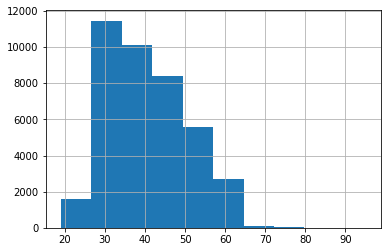

In [40]:
d.age.hist()

### Majority of the customers fall within age range of 26-42 years 

### 2. Job

In [41]:
d.job.value_counts()

blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: job, dtype: int64

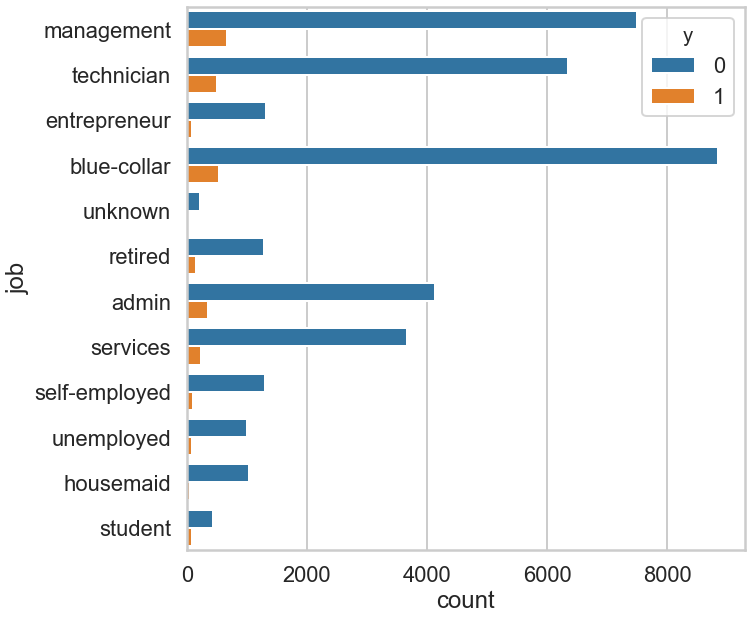

In [42]:
import seaborn as sns
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")
plt.rcParams['figure.figsize'] = (10,10)
sns.countplot(y='job', hue='y', data=d)

### Blue collared customers had the highest reach, second highest in terms of reach was management professionals. From the above plot we can infer that the response rate is better for management customers than blue collared customers

### 3. marital

In [43]:
d.marital.value_counts()

married     24386
single      10889
divorced     4725
Name: marital, dtype: int64

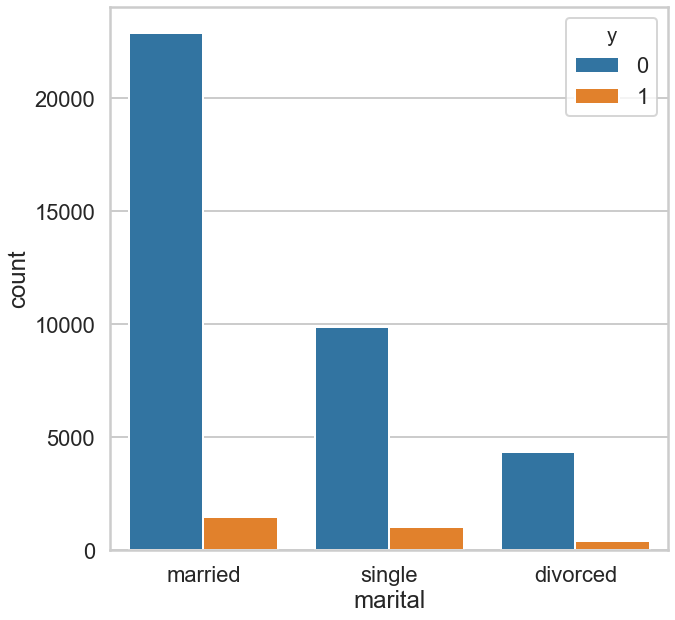

In [44]:
sns.countplot(x='marital', hue='y', data=d)

### Most customers who subscribed were to term deposits were married

### 4. education        

In [45]:
d.education.value_counts()

secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: education, dtype: int64

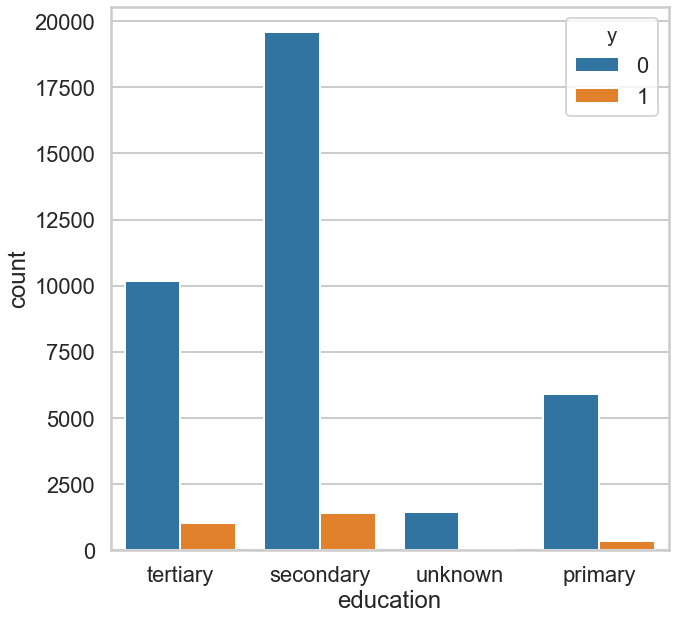

In [46]:
sns.countplot(x='education', hue='y', data=d)

### 5. default - has credit in default?    

In [47]:
d.default.value_counts()

no     39191
yes      809
Name: default, dtype: int64

In [48]:
d.groupby('default')['y'].describe()

,count,mean,std,min,25%,50%,75%,max
default,,,,,,,,
no,39191.0,0.072644,0.259555,0.0,0.0,0.0,0.0,1.0
yes,809.0,0.060569,0.238685,0.0,0.0,0.0,0.0,1.0


### Customers who do not subscribe to term deposits tend to have credit in default 

### 6. balance - average yearly balance

In [49]:
d.groupby('y')['balance'].describe()

,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
0,37104.0,1249.752533,2900.722436,-8019.0,50.0,395.0,1286.0,102127.0
1,2896.0,1588.495856,2924.894429,-3058.0,141.0,620.0,1820.5,45248.0


### Customers who subscribe to term deposits tend to have higher average yearly balance

### 7.housing - has a housing loan?

In [50]:
d.housing.value_counts()

yes    24031
no     15969
Name: housing, dtype: int64

In [51]:
d.groupby('housing')['y'].describe()

,count,mean,std,min,25%,50%,75%,max
housing,,,,,,,,
no,15969.0,0.089674,0.285723,0.0,0.0,0.0,0.0,1.0
yes,24031.0,0.060921,0.239191,0.0,0.0,0.0,0.0,1.0


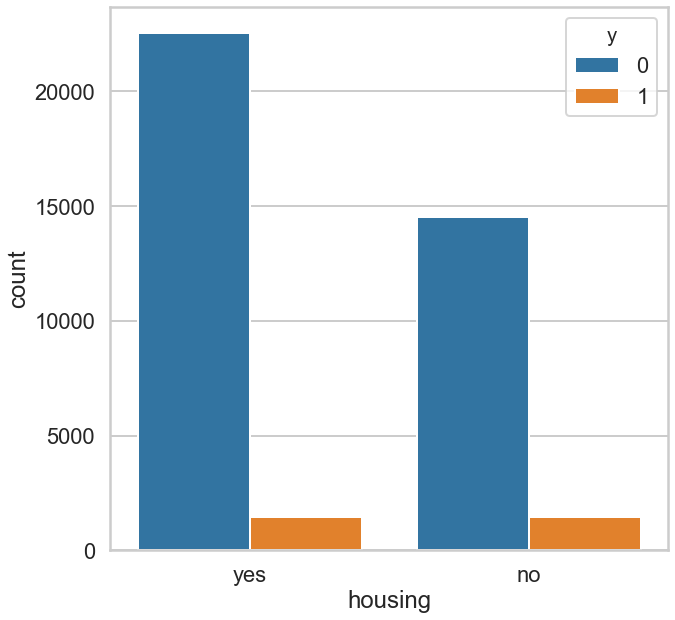

In [52]:
sns.countplot(x='housing', hue='y', data=d)

### Response rate is better for customers who do not have a housing loan

### 8. loan - has personal loan?  

In [53]:
d.loan.value_counts()

no     33070
yes     6930
Name: loan, dtype: int64

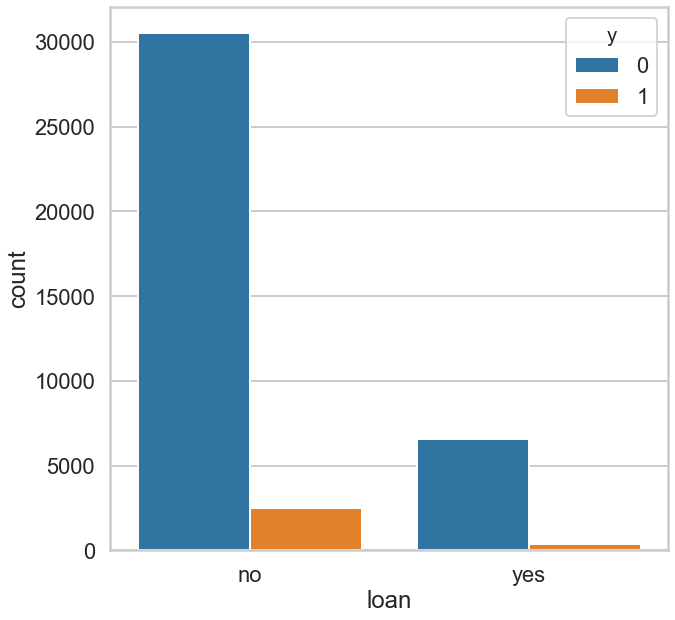

In [54]:
sns.countplot(x='loan', hue='y', data=d)

### Customers who do not have a personal loan have a higher tendency to opt for the term deposit 

### 9. contact - contact communication type

In [55]:
d.contact.value_counts()

cellular     24914
unknown      12765
telephone     2321
Name: contact, dtype: int64

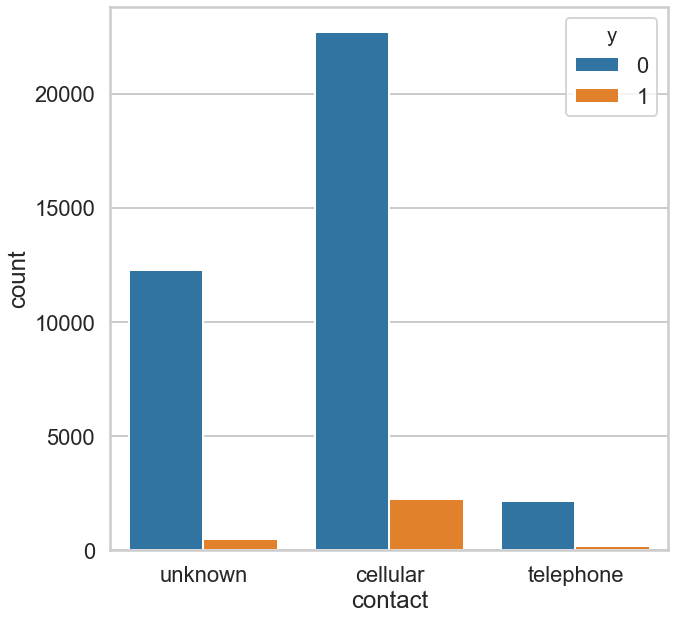

In [56]:
sns.countplot(x='contact', hue='y', data=d)

In [57]:
d.groupby('contact')['y'].describe()

,count,mean,std,min,25%,50%,75%,max
contact,,,,,,,,
cellular,24914.0,0.089628,0.285654,0.0,0.0,0.0,0.0,1.0
telephone,2321.0,0.071521,0.257748,0.0,0.0,0.0,0.0,1.0
unknown,12765.0,0.038935,0.193447,0.0,0.0,0.0,0.0,1.0


### Customers who were contacted via cellular contact have higher tendency to opt for the term deposit

### 10. day - last contact day of the month

In [58]:
d.day.value_counts()

20    2655
18    2173
21    1914
17    1812
6     1778
5     1691
19    1650
28    1650
14    1636
8     1620
7     1612
29    1600
15    1468
30    1457
9     1374
13    1325
12    1289
11    1272
16    1215
4     1183
2     1109
27     974
26     895
3      874
23     823
22     773
25     695
31     591
10     364
24     352
1      176
Name: day, dtype: int64

### ??????

### how is this feature helpful?

### 11. month - last contact month of year

In [59]:
d.month.value_counts()

may    13532
jul     6380
aug     5215
jun     4734
nov     3598
apr     2718
feb     2296
jan     1176
mar      258
oct       80
dec       13
Name: month, dtype: int64

In [60]:
d.groupby('month')['y'].describe()

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
apr,2718.0,0.165931,0.372087,0.0,0.0,0.0,0.0,1.0
aug,5215.0,0.055225,0.228441,0.0,0.0,0.0,0.0,1.0
dec,13.0,0.076923,0.277350,0.0,0.0,0.0,0.0,1.0
feb,2296.0,0.111063,0.314278,0.0,0.0,0.0,0.0,1.0
jan,1176.0,0.032313,0.176905,0.0,0.0,0.0,0.0,1.0
jul,6380.0,0.060188,0.237854,0.0,0.0,0.0,0.0,1.0
jun,4734.0,0.062104,0.241370,0.0,0.0,0.0,0.0,1.0
mar,258.0,0.484496,0.500731,0.0,0.0,0.0,1.0,1.0
may,13532.0,0.058454,0.234609,0.0,0.0,0.0,0.0,1.0


### - should this be dropped? - doesn't really convey anything

### 12. duration - last contact duration, in seconds 

y
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: duration, dtype: object

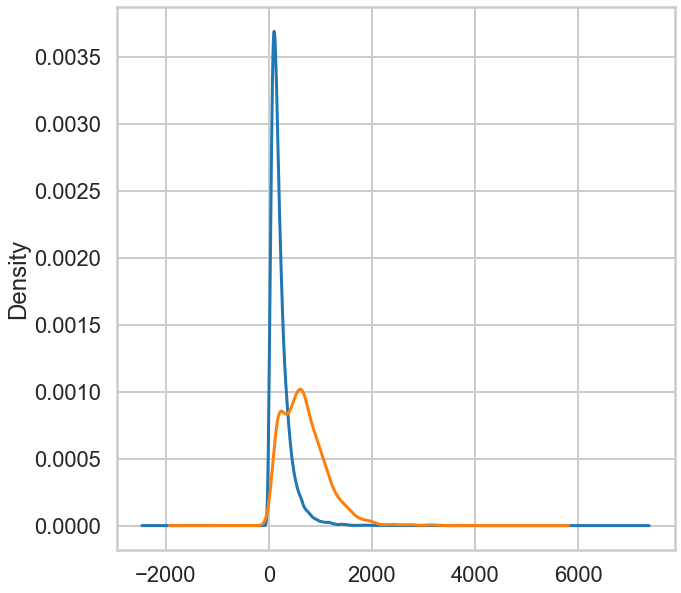

In [61]:
d.groupby('y').duration.plot(kind='kde')

### How to visualize this? And again does it convey any useful info or can be dropped?

### 13. campaign - number of contacts performed during this campaign and for this client

In [62]:
d.campaign.head()

0    1
1    1
2    1
3    1
4    1
Name: campaign, dtype: int64

In [63]:
d.groupby('y')['campaign'].describe()

,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
0,37104.0,2.918688,3.298031,1.0,1.0,2.0,3.0,63.0
1,2896.0,2.414365,2.306015,1.0,1.0,2.0,3.0,32.0


### frequent contacts cannot be attributed to term deposit subscription

### 14. y

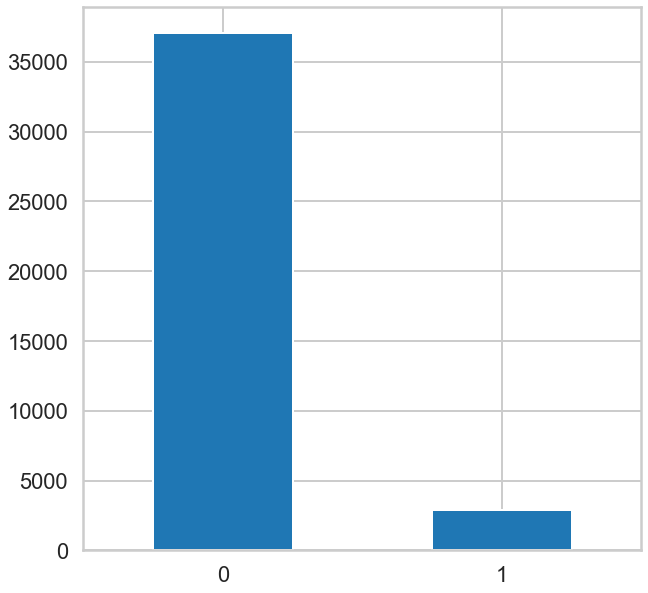

In [64]:
d['y'].value_counts().plot(kind='bar', rot=0)

#### Target variable is imbalanced. We will use SMOTE (synthetic monitoring over-sampling technique) to generate synthetic samples from minor class

SMOTE - instead of simply duplicating observations, it creates new observations along the lines of a randomly chosen point and its nearest neighbors. Basically you’re simulating some additional variation in the data (within the established bounds of your minority class), reducing the danger of overfitting (although not eliminating it).

### Apply this step after train test split

### First lets check for correlation between the features

In [65]:
d.corr()

,age,balance,day,duration,campaign,y
age,1.000000,0.081517,-0.011689,-0.036270,0.016204,-0.020273
balance,0.081517,1.000000,0.011662,0.014072,-0.008137,0.030232
day,-0.011689,0.011662,1.000000,-0.032983,0.165429,-0.006420
duration,-0.036270,0.014072,-0.032983,1.000000,-0.088387,0.461169
campaign,0.016204,-0.008137,0.165429,-0.088387,1.000000,-0.040350
y,-0.020273,0.030232,-0.006420,0.461169,-0.040350,1.000000


### How to check correlation including both categorical and numeric features?

### Applying SMOTE

In [66]:
#first separate the classes
#X_train, X_test, Y_train, Y_test

def resamplingDataPrep(X_train, Y_train, target_var): 
    # concatenate our training data back together
    resampling = X_train.copy()
    resampling[target_var] = Y_train.values
    # separate minority and majority classes
    majority_class = resampling[resampling[target_var]==0]
    minority_class = resampling[resampling[target_var]==1]
    # Get a class count to understand the class imbalance.
    print('majority_class: '+ str(len(majority_class)))
    print('minority_class: '+ str(len(minority_class)))
    return majority_class, minority_class

In [67]:
!pip install imblearn

In [68]:
#performing the upsample
#import imblearn
from imblearn.over_sampling import SMOTE
def upsample_SMOTE(X_train, Y_train, ratio=1.0):
    """Upsamples minority class using SMOTE.
    Ratio argument is the percentage of the upsampled minority class in relation
    to the majority class. Default is 1.0
    """
    sm = SMOTE(random_state=23, sampling_strategy=ratio)
    X_train_sm, Y_train_sm = sm.fit_resample(X_train, Y_train)
    print(len(X_train_sm), len(Y_train_sm))
    return X_train_sm, Y_train_sm

In [69]:
resamplingDataPrep(X_train, Y_train, 'y')

majority_class: 31538
minority_class: 2462


(            age   balance       day  duration  campaign  job_admin  \
 26368  0.250000  0.074755  0.633333  0.014233  0.000000        0.0   
 37505  0.144737  0.073766  0.400000  0.024197  0.032258        0.0   
 21511  0.368421  0.072803  0.600000  0.043310  0.016129        0.0   
 23076  0.539474  0.072803  0.833333  0.073607  0.080645        0.0   
 30504  0.250000  0.075827  0.133333  0.123221  0.016129        0.0   
 ...         ...       ...       ...       ...       ...        ...   
 28697  0.250000  0.086376  0.966667  0.068930  0.016129        0.0   
 30961  0.157895  0.073194  0.266667  0.060390  0.096774        0.0   
 32201  0.184211  0.085487  0.500000  0.075234  0.000000        0.0   
 328    0.500000  0.074674  0.133333  0.043920  0.032258        0.0   
 17140  0.092105  0.072822  0.800000  0.004473  0.241935        0.0   
 
        job_blue-collar  job_entrepreneur  job_housemaid  job_management  ...  \
 26368              0.0               0.0            0.0         

In [70]:
upsample_SMOTE(X_train, Y_train, ratio=1.0)

63076 63076


(            age   balance       day  duration  campaign  job_admin  \
 0      0.250000  0.074755  0.633333  0.014233  0.000000        0.0   
 1      0.144737  0.073766  0.400000  0.024197  0.032258        0.0   
 2      0.368421  0.072803  0.600000  0.043310  0.016129        0.0   
 3      0.539474  0.072803  0.833333  0.073607  0.080645        0.0   
 4      0.250000  0.075827  0.133333  0.123221  0.016129        0.0   
 ...         ...       ...       ...       ...       ...        ...   
 63071  0.453225  0.074262  0.548170  0.139121  0.030906        0.0   
 63072  0.186127  0.137451  0.947249  0.083460  0.002349        0.0   
 63073  0.144965  0.073348  0.933910  0.075867  0.000000        0.0   
 63074  0.412307  0.079451  0.410322  0.187136  0.011134        0.0   
 63075  0.091821  0.084450  0.471703  0.025338  0.016129        0.0   
 
        job_blue-collar  job_entrepreneur  job_housemaid  job_management  ...  \
 0             0.000000               0.0            0.0         

In [72]:
X_train.shape, Y_train.shape

((34000, 44), (34000,))

In [88]:
X_train_sm, Y_train_sm = upsample_SMOTE(X_train, Y_train, ratio=1.0)

63076 63076


In [89]:
X_train_sm.shape

(63076, 44)

In [90]:
Y_train_sm.value_counts()

1.0    31538
0.0    31538
Name: y, dtype: int64


 Logistic Regression


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



 Confusion Matrix


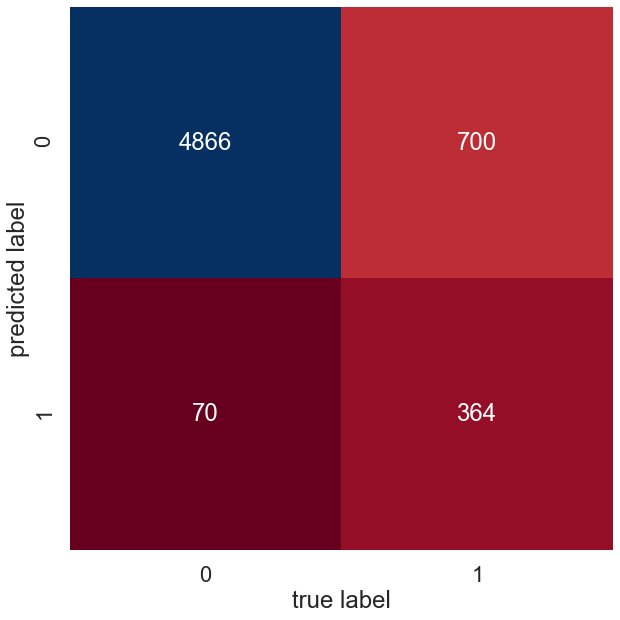


 Classification Report 

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93      5566
         1.0       0.34      0.84      0.49       434

    accuracy                           0.87      6000
   macro avg       0.66      0.86      0.71      6000
weighted avg       0.94      0.87      0.89      6000

Accuracy:  0.8716666666666667
Precision Score:  0.34210526315789475
Recall Score:  0.8387096774193549
F1 Score:  0.485981308411215
AUC:  0.9295666083247367


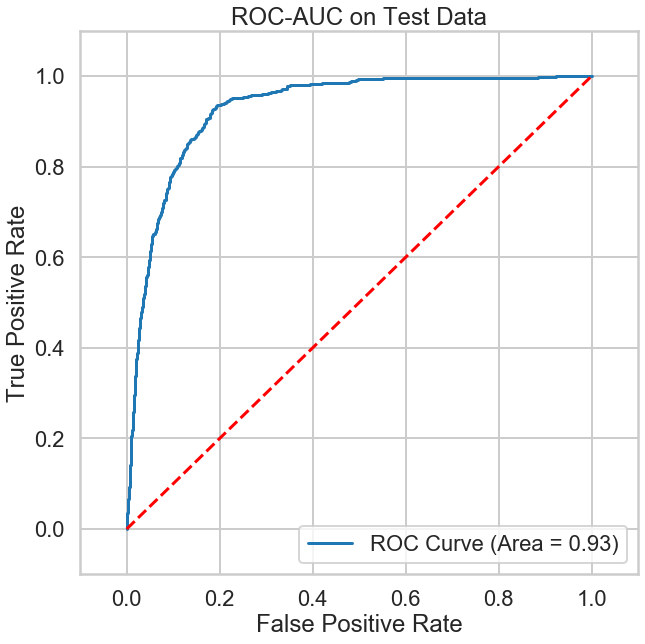

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

 Decision Tree

 Confusion Matrix


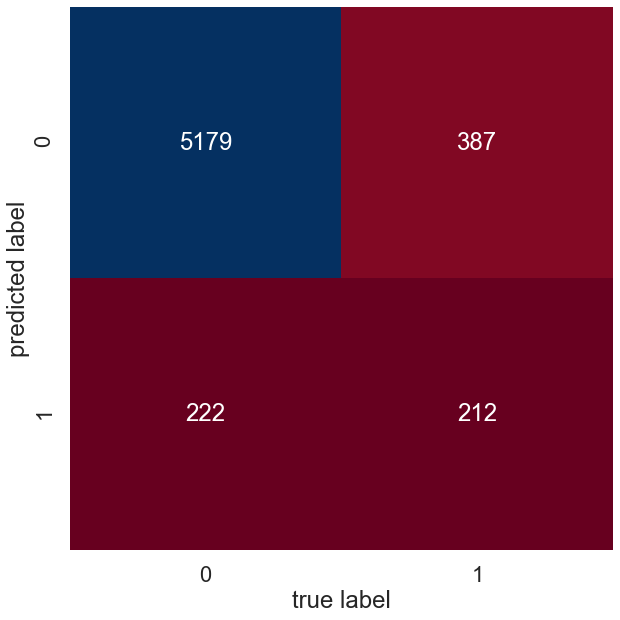


 Classification Report 

              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94      5566
         1.0       0.35      0.49      0.41       434

    accuracy                           0.90      6000
   macro avg       0.66      0.71      0.68      6000
weighted avg       0.92      0.90      0.91      6000

Accuracy:  0.8985
Precision Score:  0.35392320534223703
Recall Score:  0.48847926267281105
F1 Score:  0.4104549854791868
AUC:  0.7094749888642532


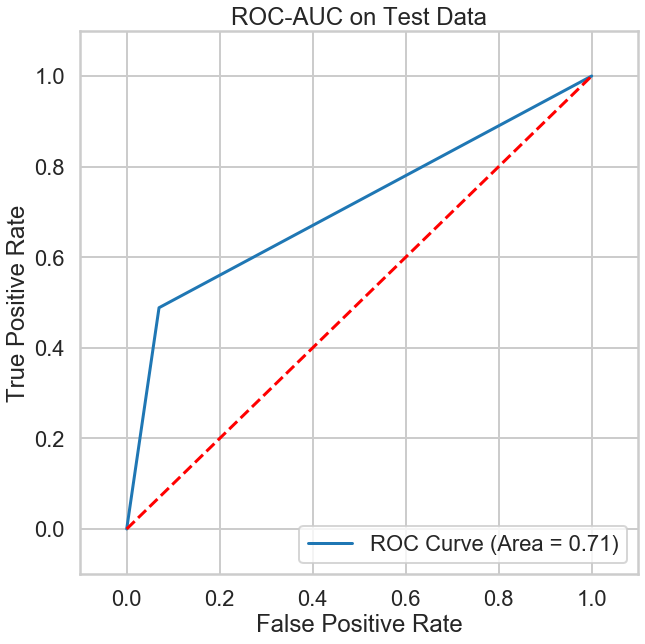

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

 Random Forest

 Confusion Matrix


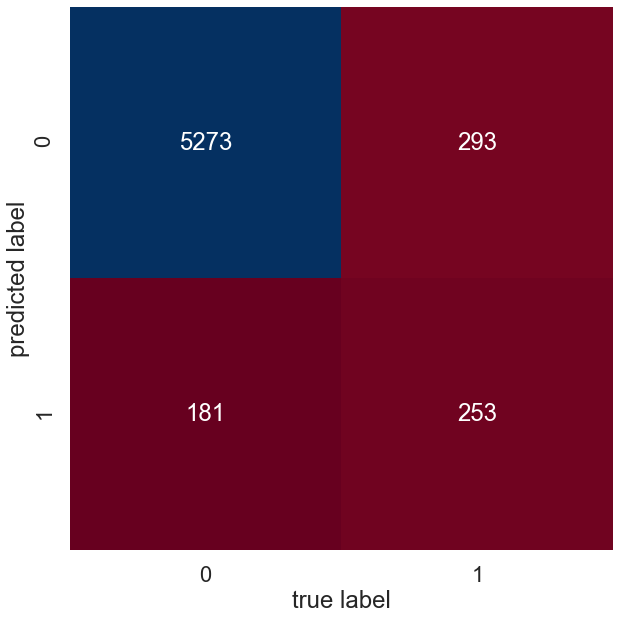


 Classification Report 

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      5566
         1.0       0.46      0.58      0.52       434

    accuracy                           0.92      6000
   macro avg       0.72      0.77      0.74      6000
weighted avg       0.93      0.92      0.93      6000

Accuracy:  0.921
Precision Score:  0.4633699633699634
Recall Score:  0.5829493087557603
F1 Score:  0.516326530612245
AUC:  0.9352882709538327


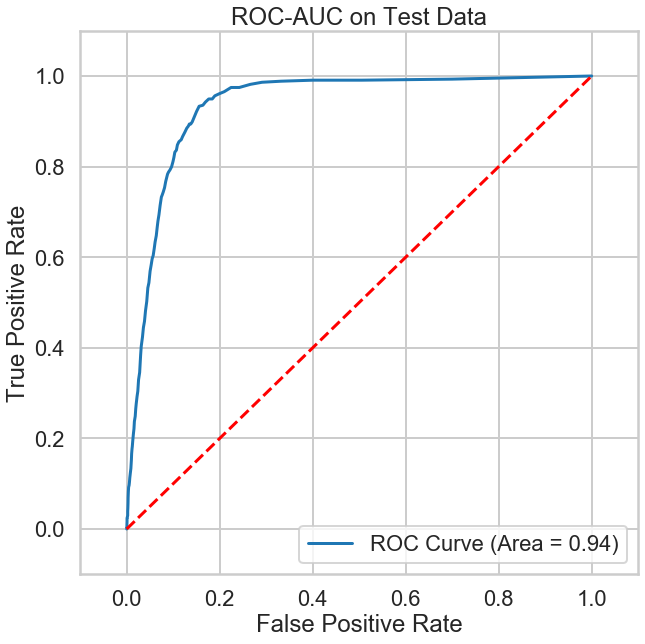

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

 Gradient Boosting

 Confusion Matrix


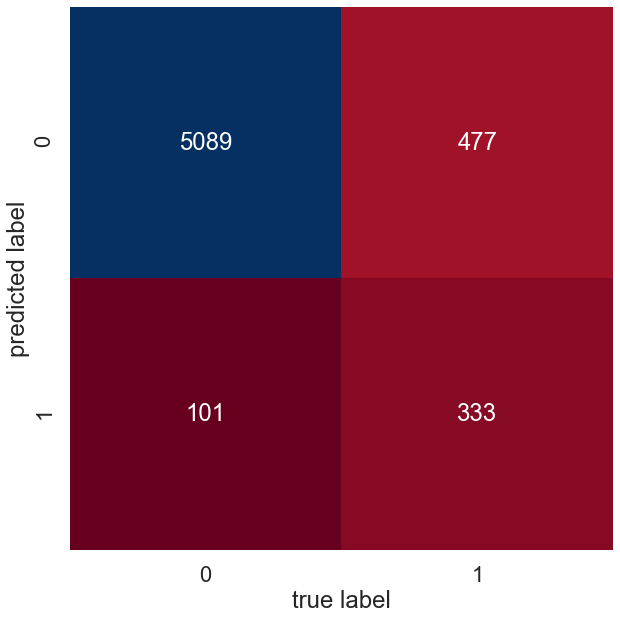


 Classification Report 

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.95      5566
         1.0       0.41      0.77      0.54       434

    accuracy                           0.90      6000
   macro avg       0.70      0.84      0.74      6000
weighted avg       0.94      0.90      0.92      6000

Accuracy:  0.9036666666666666
Precision Score:  0.4111111111111111
Recall Score:  0.7672811059907834
F1 Score:  0.5353697749196141
AUC:  0.9370141047273521


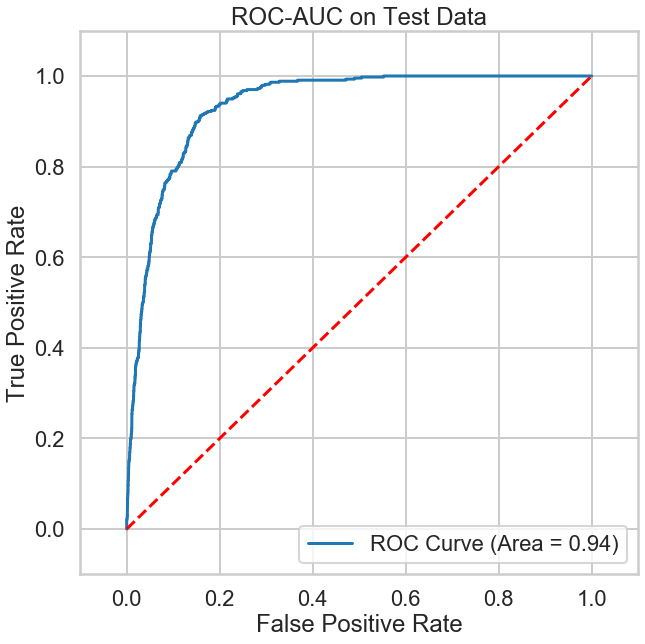

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------


In [91]:
model_data(X_train_sm, X_test, Y_train_sm, Y_test)

In [92]:
lr = LogisticRegression()
clf_model_lr = lr.fit(X_train_sm, Y_train_sm)
kfold = KFold(n_splits=5, random_state=25, shuffle=True)
results = cross_val_score(clf_model_lr, X_test, Y_test, cv=kfold)
results = results * 100
results = np.round(results,2)
print("Cross validation with Logistic Regression")
print("Cross Validation Accuracy : ", round(results.mean(), 2))
print("Cross Validation Accuracy in every fold : ", results)
       
dt = DecisionTreeClassifier()
clf_model_dt = dt.fit(X_train_sm, Y_train_sm)
kfold = KFold(n_splits=5, random_state=25, shuffle=True)
results = cross_val_score(clf_model_dt, X_test, Y_test, cv=kfold)
results = results * 100
results = np.round(results,2)
print("\nCross validation with Decision Tree Classifier")
print("Cross Validation Accuracy : ", round(results.mean(), 2))
print("Cross Validation Accuracy in every fold : ", results)
    

rf = RandomForestClassifier()
clf_model_rf = rf.fit(X_train_sm, Y_train_sm)
kfold = KFold(n_splits=5, random_state=25, shuffle=True)
results = cross_val_score(clf_model_rf, X_test, Y_test, cv=kfold)
results = results * 100
results = np.round(results,2)
print("\nCross validation with Random Forest Classifier")
print("Cross Validation Accuracy : ", round(results.mean(), 2))
print("Cross Validation Accuracy in every fold : ", results)

gb = GradientBoostingClassifier()
clf_model_gb = gb.fit(X_train_sm, Y_train_sm)
kfold = KFold(n_splits=5, random_state=25, shuffle=True)
results = cross_val_score(clf_model_gb, X_test, Y_test, cv=kfold)
results = results * 100
results = np.round(results,2)
print("\nCross validation with Graident Boost Classifier")
print("Cross Validation Accuracy : ", round(results.mean(), 2))
print("Cross Validation Accuracy in every fold : ", results)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

Cross validation with Logistic Regression
Cross Validation Accuracy :  93.0
Cross Validation Accuracy in every fold :  [92.67 93.83 93.17 92.83 92.5 ]

Cross validation with Decision Tree Classifier
Cross Validation Accuracy :  90.85
Cross Validation Accuracy in every fold :  [90.67 90.42 90.83 91.17 91.17]

Cross validation with Random Forest Classifier
Cross Validation Accuracy :  92.93
Cross Validation Accuracy in every fold :  [92.75 93.42 93.25 93.08 92.17]

Cross validation with Graident Boost Classifier
Cross Validation Accuracy :  93.28
Cross Validation Accuracy in every fold :  [93.33 92.92 94.25 92.92 93.  ]


In [94]:
rf.predict_proba(X_test)

array([[1.  , 0.  ],
       [0.93, 0.07],
       [1.  , 0.  ],
       ...,
       [0.99, 0.01],
       [1.  , 0.  ],
       [0.99, 0.01]])